<font color = 'blue'>
Content: 

1. [Load Python Pakages](#1)
2. [First look to data](#2)
3. [Missing values](#3)
4. [Descriptive statistics](#4)   
5. [Exploratory Data Analysis](#5)   
6. [Feature engineering](#6)
7. [Modeling and hyperparameter tuning](#7)


<a id = "1"></a><br>
# Load Python Pakages


In [3]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder



#feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel

#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import clone


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import make_scorer


import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


# Dealing with imbalanced target (not tried)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 42

<a id = "2"></a><br>
#  First look to data

In [4]:
train_df = pd.read_csv(r"C:\Users\tomti\Desktop\Data Science stuffs\Project Skin cancer\train-metadata.csv", index_col='isic_id')
test_df  = pd.read_csv(r"C:\Users\tomti\Desktop\Data Science stuffs\Project Skin cancer\test-metadata.csv", index_col='isic_id')

In [5]:
train_df.head()

,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
isic_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [6]:
print(train_df.shape)
print(test_df.shape)

(401059, 54)
(3, 43)


In [7]:
#columns in train and test sets do not match
#common columns in train and test sets
common_cols = train_df.columns.intersection(test_df.columns).tolist()

#append target
common_cols.append('target')

#train_df
train_df = train_df[common_cols]

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401059 entries, ISIC_0015670 to ISIC_9999967
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   patient_id                   401059 non-null  object 
 1   age_approx                   398261 non-null  float64
 2   sex                          389542 non-null  object 
 3   anatom_site_general          395303 non-null  object 
 4   clin_size_long_diam_mm       401059 non-null  float64
 5   image_type                   401059 non-null  object 
 6   tbp_tile_type                401059 non-null  object 
 7   tbp_lv_A                     401059 non-null  float64
 8   tbp_lv_Aext                  401059 non-null  float64
 9   tbp_lv_B                     401059 non-null  float64
 10  tbp_lv_Bext                  401059 non-null  float64
 11  tbp_lv_C                     401059 non-null  float64
 12  tbp_lv_Cext                  401059 non-null  

<a id = "3"></a><br>
## Missing values

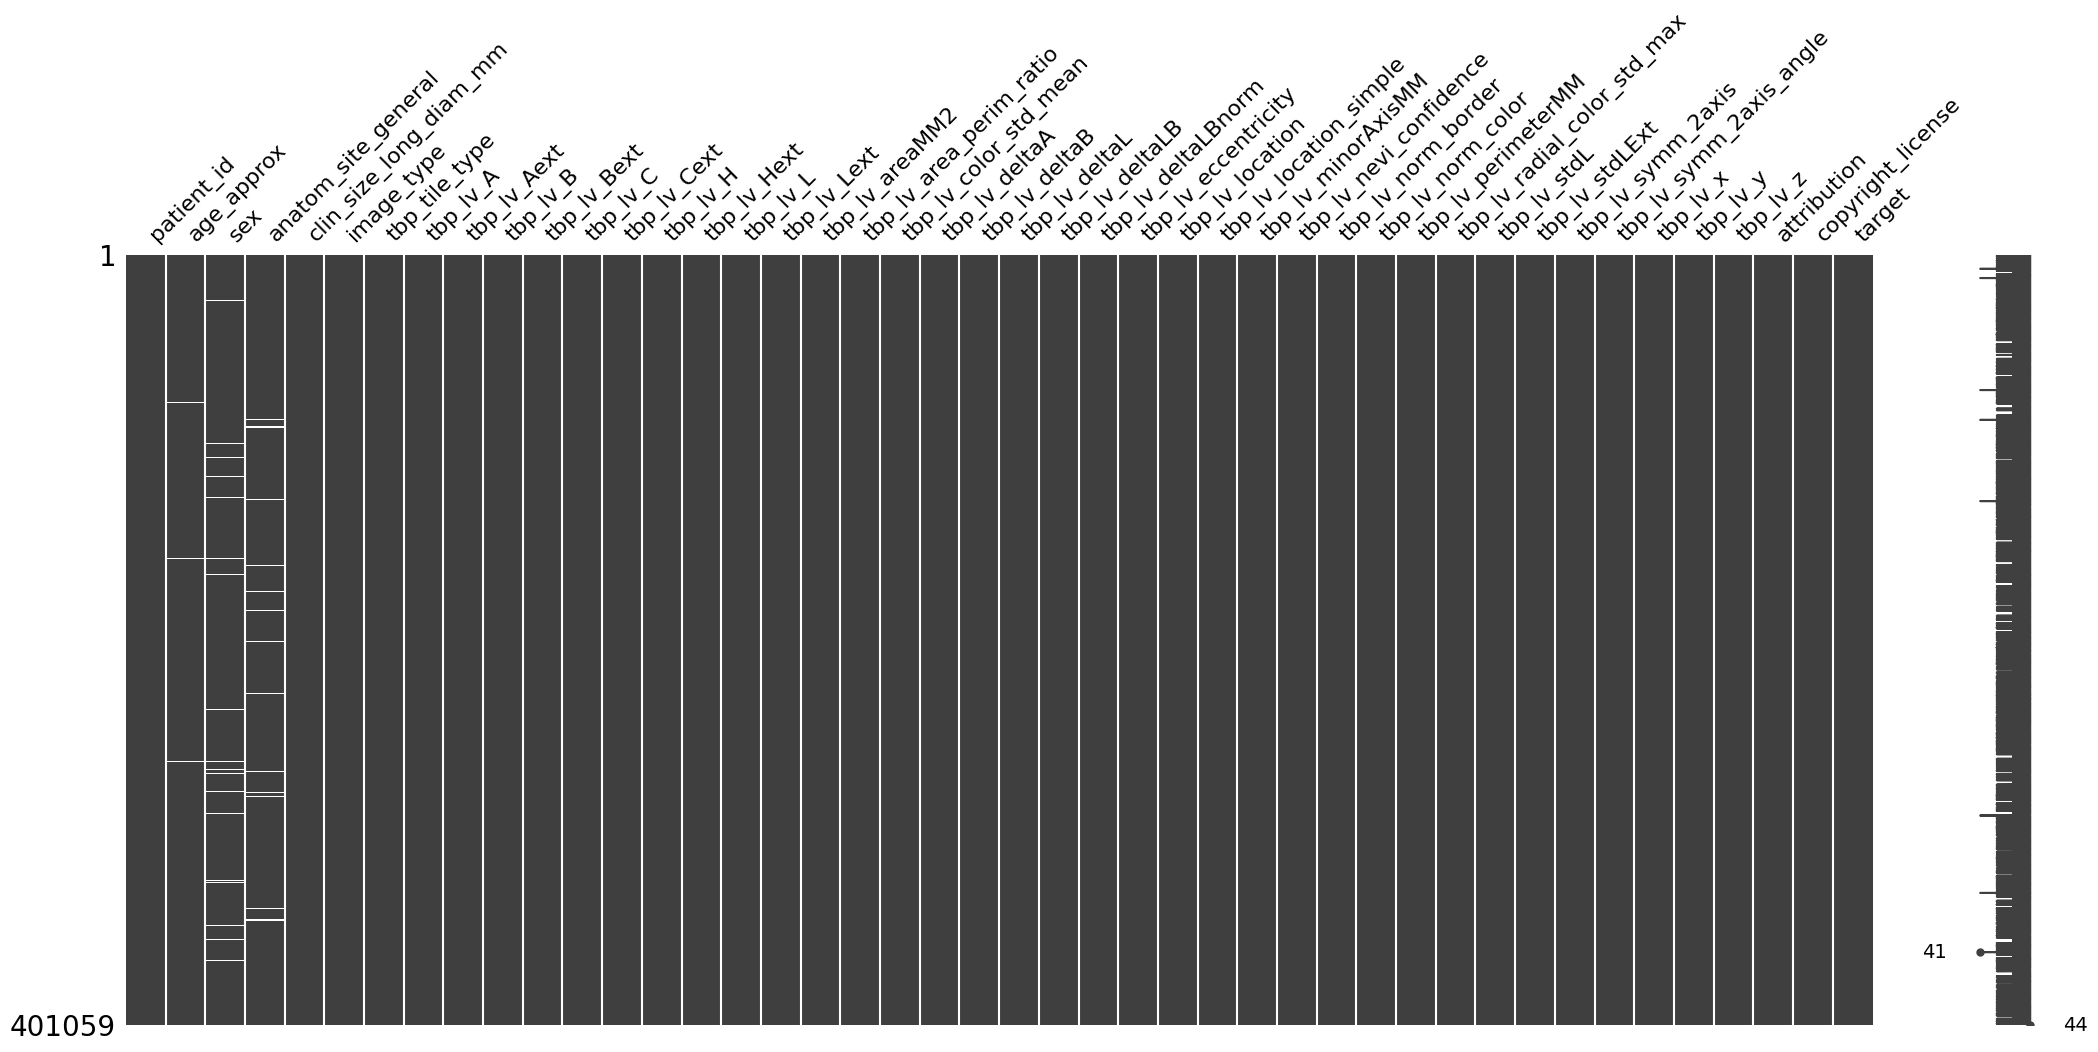

In [9]:
msno.matrix(train_df)
plt.show()

In [10]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
sex,11517,2.871647
anatom_site_general,5756,1.435200
age_approx,2798,0.697653


<a id = "4"></a><br>
## Descriptive statistics

In [11]:
#descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age_approx,398261.0,58.012986,13.596165,5.000000,50.000000,60.000000,70.000000,85.000000
clin_size_long_diam_mm,401059.0,3.930827,1.743068,1.000000,2.840000,3.370000,4.380000,28.400000
tbp_lv_A,401059.0,19.974007,3.999489,-2.487115,17.330821,19.801910,22.304628,48.189610
tbp_lv_Aext,401059.0,14.919247,3.529384,-9.080269,12.469740,14.713930,17.137175,37.021680
tbp_lv_B,401059.0,28.281706,5.278676,-0.730989,24.704372,28.171570,31.637429,54.306900
tbp_lv_Bext,401059.0,26.913015,4.482994,9.237066,23.848125,26.701704,29.679913,48.372700
tbp_lv_C,401059.0,34.786341,5.708469,3.054228,31.003148,34.822580,38.430298,58.765170
tbp_lv_Cext,401059.0,30.921279,4.829345,11.846520,27.658285,30.804893,33.963868,54.305290
tbp_lv_H,401059.0,54.653689,5.520849,-1.574164,51.566273,55.035632,58.298184,105.875784
tbp_lv_Hext,401059.0,60.996869,5.631909,28.436490,57.297630,61.109173,64.905025,130.983300


In [12]:
train_df['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

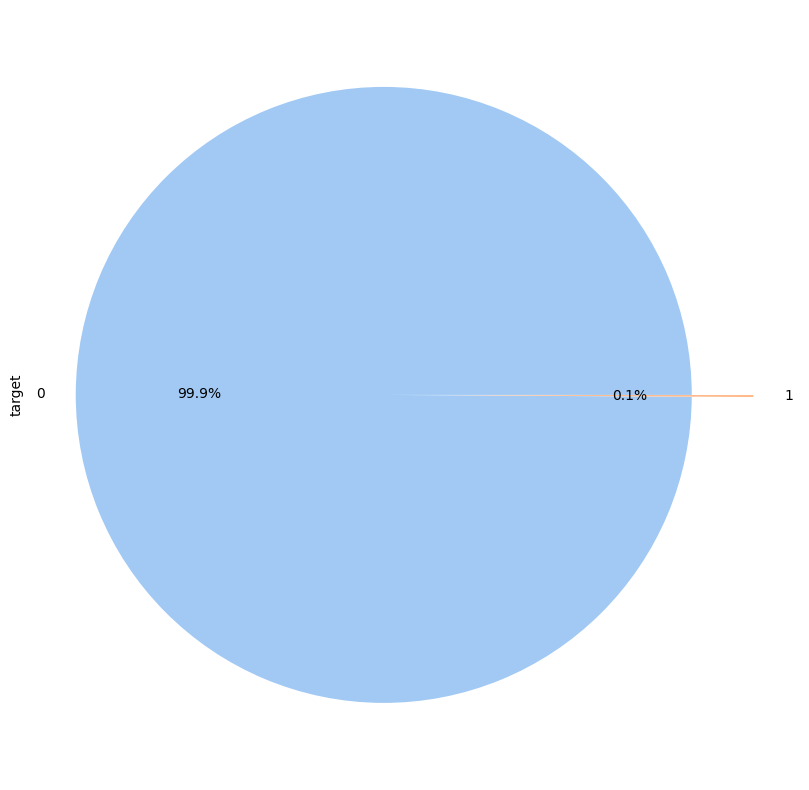

In [13]:
#Target Distribution plot
plt.figure(figsize=(10,10))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('target')['target'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

Overly imbalanced...

<a id = "5"></a><br>
# Exploratory Data Analysis

In [14]:
# Store continuous and categorical features to different lists for visualization purposes


#categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()


categorical_features = [
 'sex',
 'anatom_site_general',
 'tbp_tile_type',
 'tbp_lv_location',
 'tbp_lv_location_simple',
 'attribution',
 'copyright_license']


numerical_features = train_df.select_dtypes(include=['float64']).columns.tolist()


features = numerical_features + categorical_features

In [15]:
#check for cardinality
train_df[categorical_features].nunique().sort_values()

sex                        2
tbp_tile_type              2
copyright_license          3
anatom_site_general        5
attribution                7
tbp_lv_location_simple     8
tbp_lv_location           21
dtype: int64

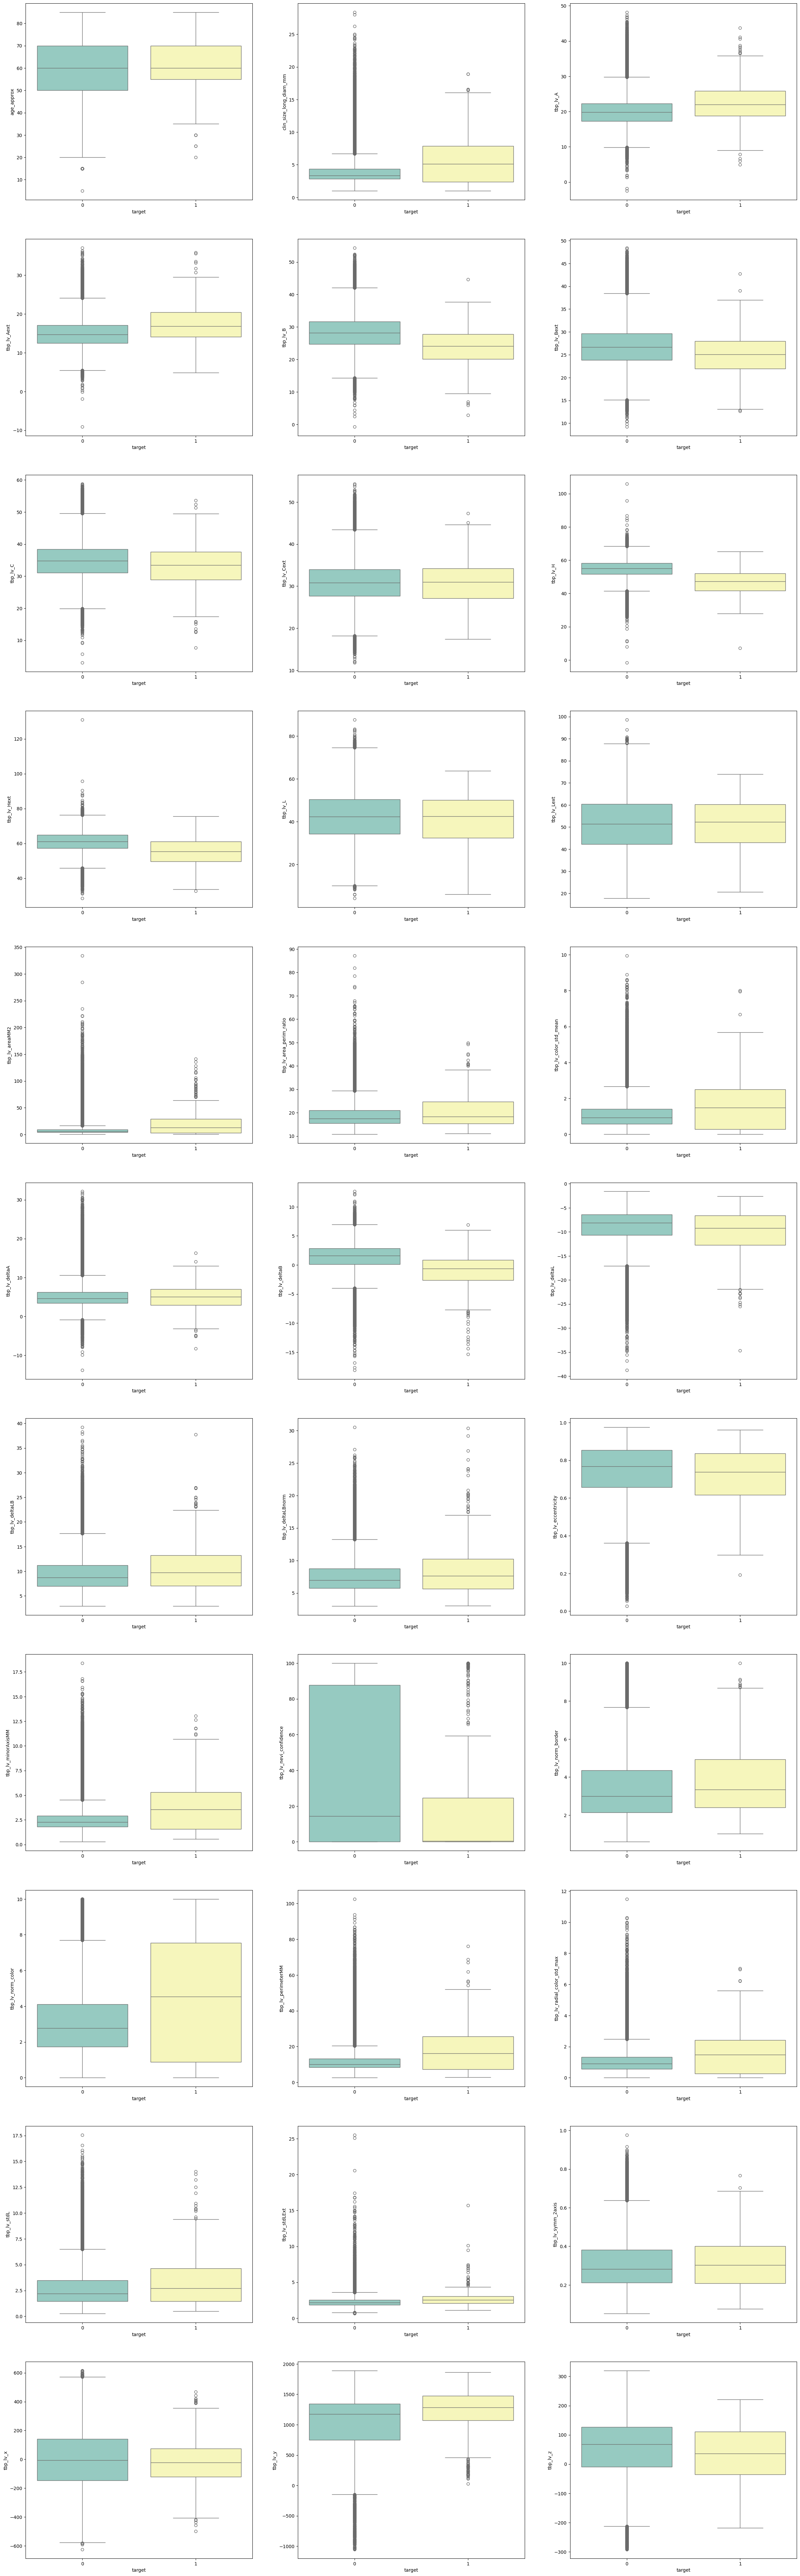

In [16]:
#Box-plots
fig, ax = plt.subplots(11, 3, figsize=(30, 100))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(x='target', y=var, data=train_df, ax=subplot, palette='Set3')

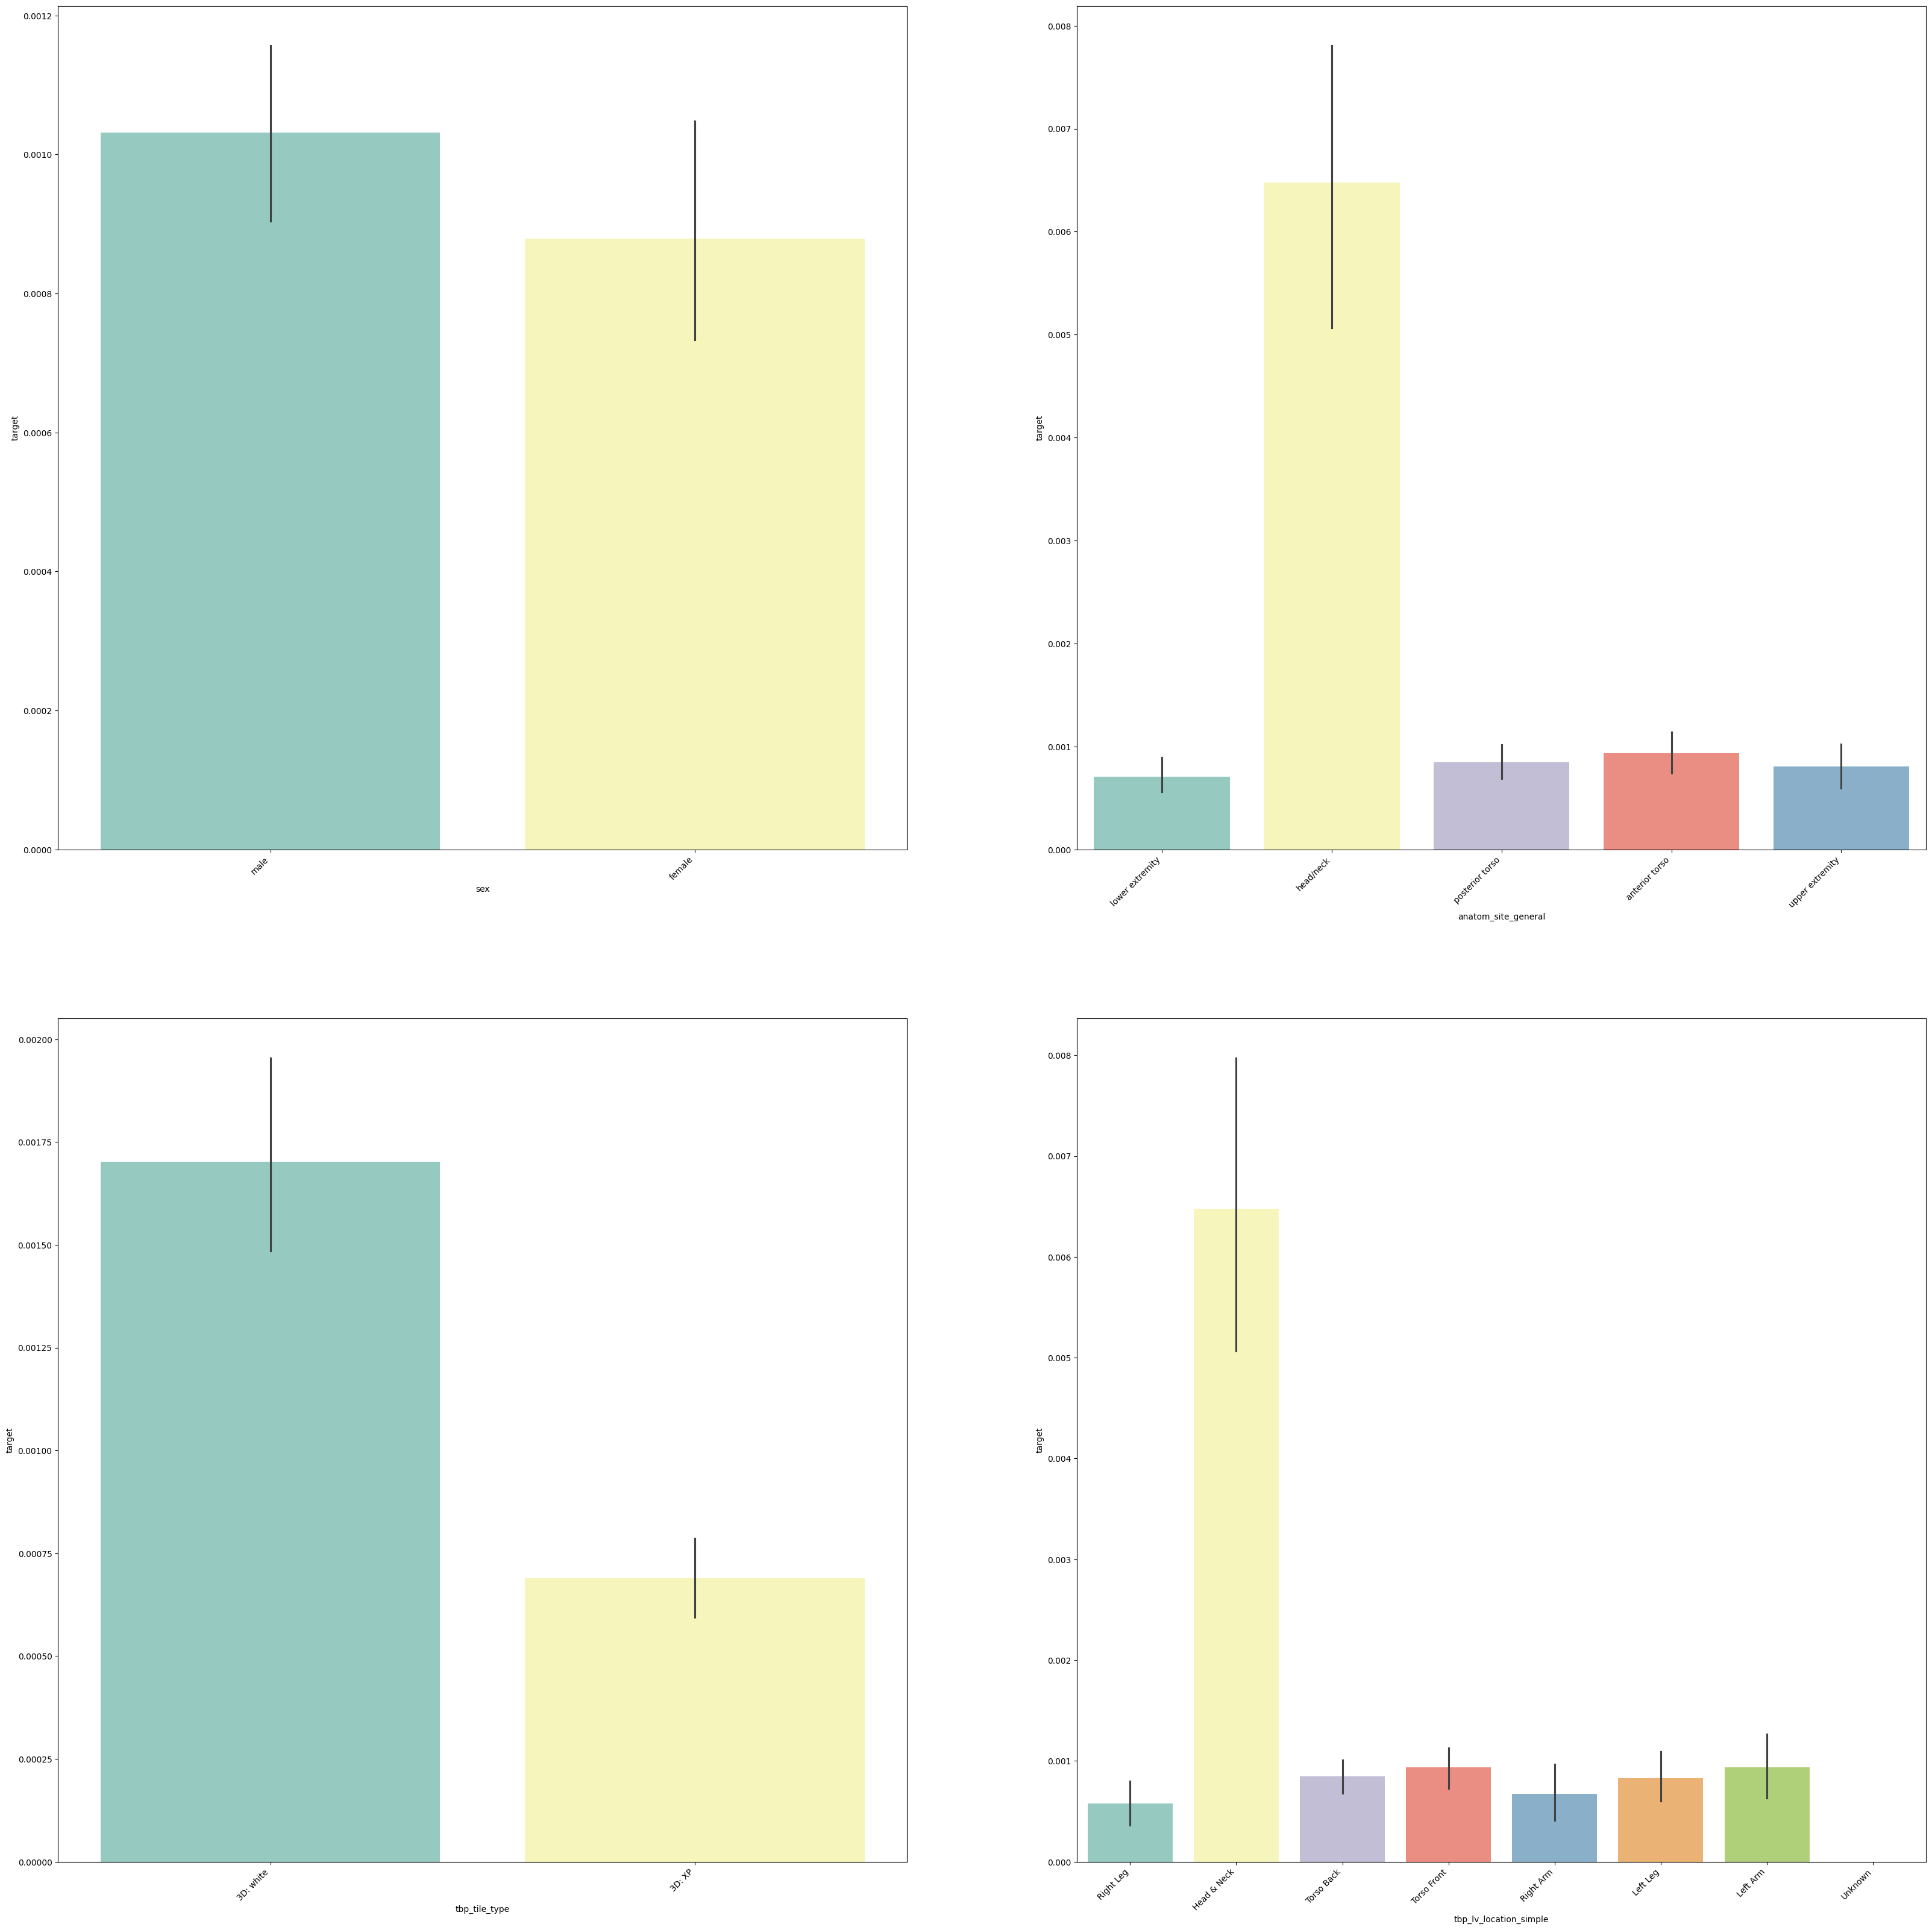

In [17]:
#Categoricals
fig, ax = plt.subplots(2, 2, figsize=(40, 40))
for var, subplot in zip(['sex', 'anatom_site_general', 'tbp_tile_type',  'tbp_lv_location_simple'], ax.flatten()):
    sns.barplot(x=var,y= 'target',  data=train_df, ax=subplot, palette='Set3')
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=45, ha='right')
    
    

In [18]:
y = train_df['target']

In [19]:
# determine the mutual information for features
#we need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[numerical_features ]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


,Numerical_Feature_MI
age_approx,0.010496
clin_size_long_diam_mm,0.001658
tbp_lv_areaMM2,0.001294
tbp_lv_perimeterMM,0.001240
tbp_lv_minorAxisMM,0.001179
tbp_lv_H,0.000802
tbp_lv_Hext,0.000640
tbp_lv_radial_color_std_max,0.000631
tbp_lv_norm_color,0.000595
tbp_lv_deltaLBnorm,0.000595


In [20]:
top_5_numerical_features = mutual_info.head(5).index.values.tolist()


In [21]:
mutual_df_categorical = train_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
tbp_tile_type,0.070817
copyright_license,0.042028
anatom_site_general,0.036583
tbp_lv_location_simple,0.030479
attribution,0.021670
tbp_lv_location,0.018637
sex,0.009285


In [22]:
#pair-plot for most important features
#sns.pairplot(train_df[top_5_numerical_features + ["target"]], hue="target",  palette='Set3', corner=True)

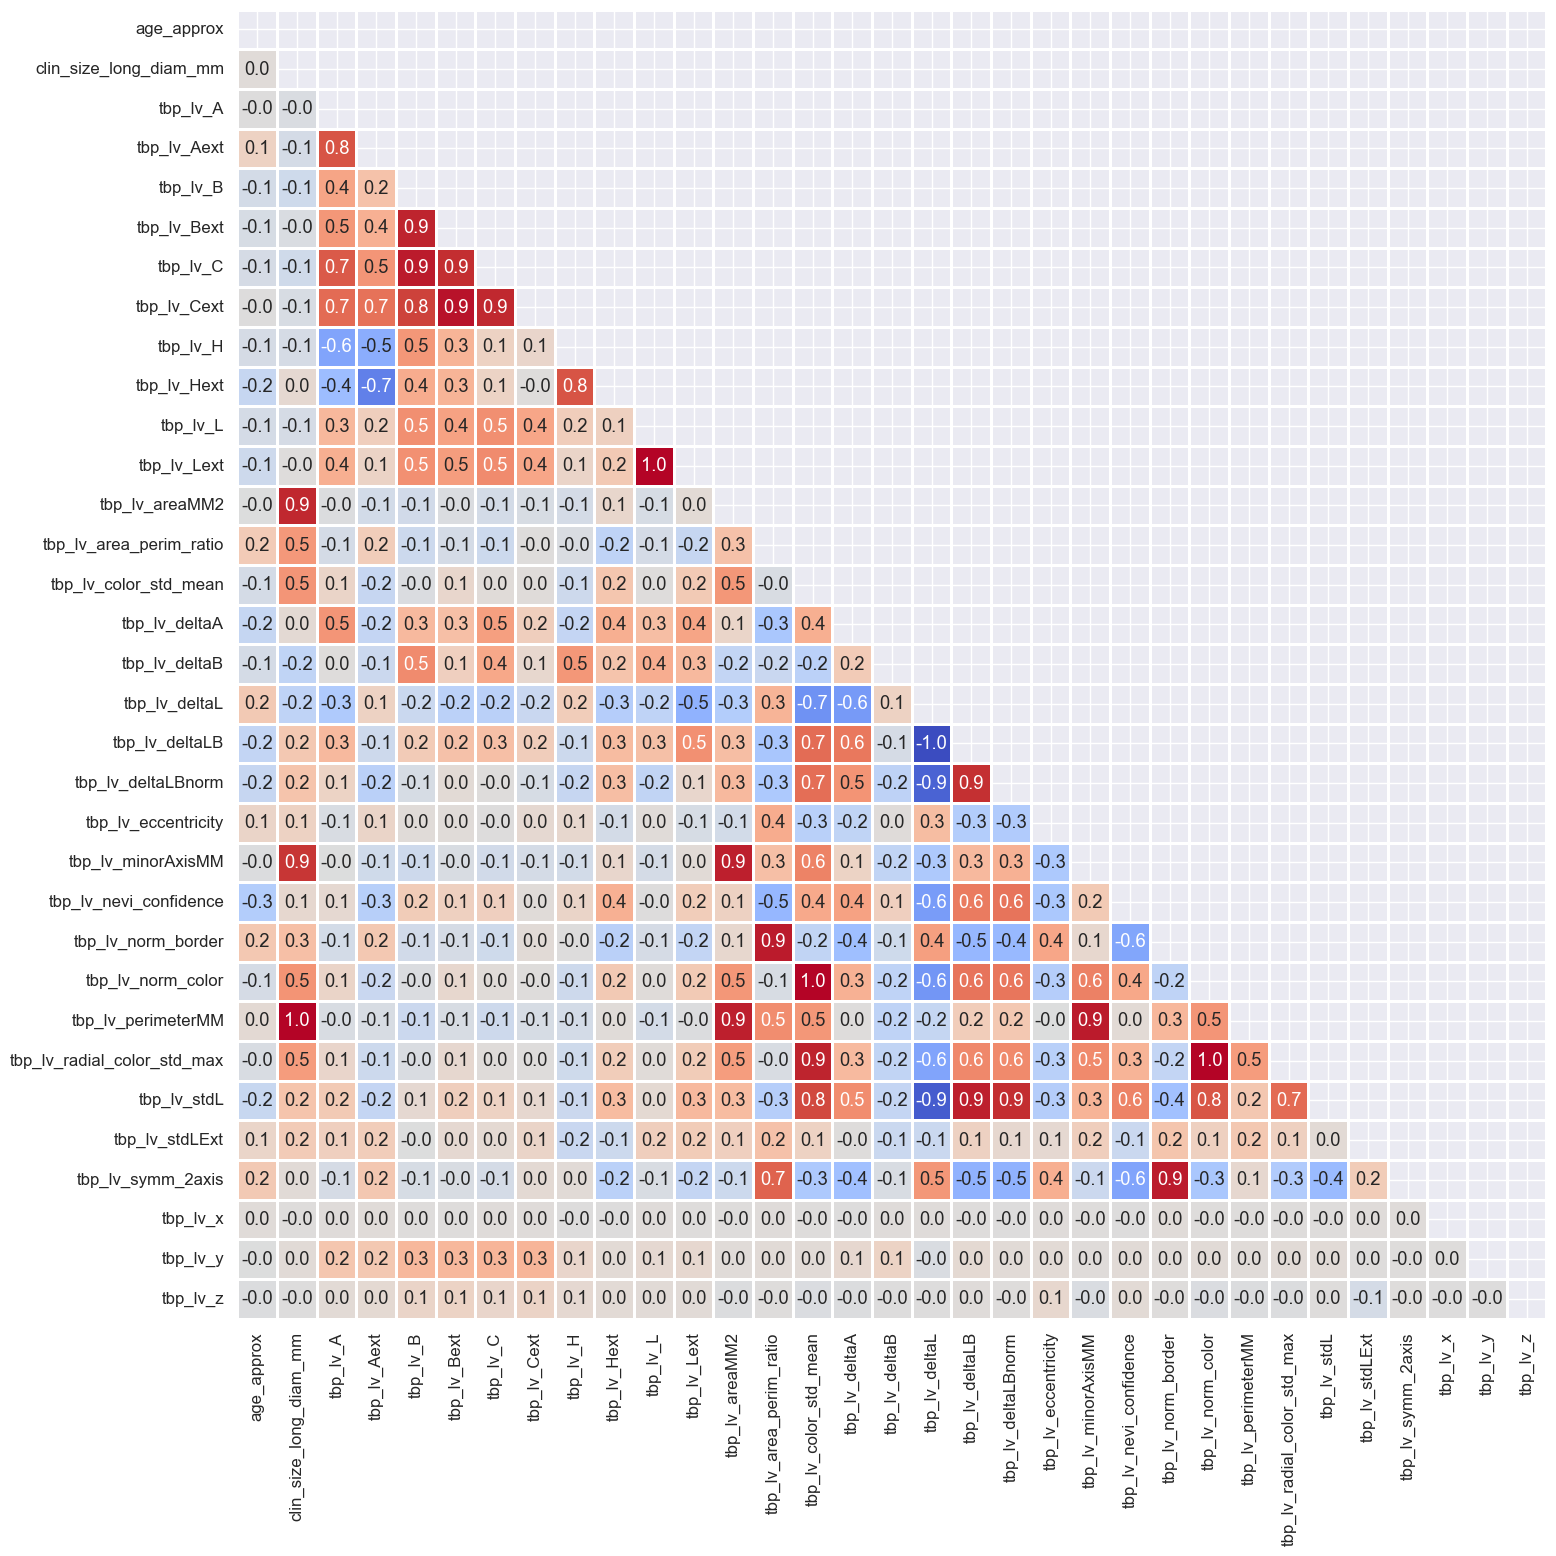

In [23]:
# Display correlations between numerical features

sns.set(font_scale=1.1)
correlation_train = train_df[numerical_features].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "6"></a><br>
## Feature Engineering

In [24]:
# reference: https://www.kaggle.com/code/snnclsr/lgbm-baseline-with-new-features

def feature_engineering(df, categorical_features):
    # New features to try...
    df["lesion_size_ratio"]              = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"]             = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"]                   = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"]             = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"]        = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"]              = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"]               = df["tbp_lv_color_std_mean"] / (df["tbp_lv_radial_color_std_max"]+1e-4)
    df["3d_position_distance"]           = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"]        = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"]        = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["symmetry_border_consistency"]    = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"]              = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    df["size_age_interaction"]           = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"]      = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"]          = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"]         = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"]           = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"]                = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"]         = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"]            = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"]               = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"]    = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"]          = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"]       = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"]     = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4
    df[categorical_features] = df[categorical_features].astype('category')
    df = df.drop('image_type',axis=1)

    
    return df
    

In [25]:
train_df= feature_engineering(train_df, categorical_features)
test_df = feature_engineering(test_df, categorical_features)

<a id = "7"></a><br>
## Modelling

In [26]:
#seperate target
y = train_df['target']
train_df = train_df.drop(['target'], axis=1)


In [27]:
#define competition metric
def p_roc_auc_score(y_true, y_pred):
    min_tpr = 0.80
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0*np.asarray(y_pred)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError('Expected min_tpr in range [0, 1), got: %r' % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, 'right')
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

p_roc_auc_scorer = make_scorer(p_roc_auc_score, needs_proba=True)

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation

cv = StratifiedGroupKFold(n_splits=10)

def preprocess_catboost(train_df, test_data, cat_features):
    for col in cat_features:
        train_df[col] = train_df[col].astype(str).fillna('NaN')
        test_data[col] = test_data[col].astype(str).fillna('NaN')
    return train_df, test_data



def cross_validate_score(model, train_df, y, cv, test_data):
    val_scores = []
    test_probs = np.zeros((test_data.shape[0],))
    oof_preds = np.zeros((train_df.shape[0],))

    groups = train_df['patient_id']
    train_df = train_df.drop('patient_id', axis=1)
    test_data = test_data.drop('patient_id', axis=1)

    if isinstance(model, CatBoostClassifier):
        cat_features = model.get_params().get('cat_features', [])
        train_df, test_data = preprocess_catboost(train_df, test_data, cat_features)

    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, y, groups)):
        X_train = train_df.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        X_val = train_df.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        model = clone(model)

        eval_set = [(X_val, y_val)]
        
        if isinstance(model, LGBMClassifier):
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                callbacks=[early_stopping(50)],
            )
        else:  # For CatBoost and XGBoost
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                early_stopping_rounds=50,
                verbose=False
            )
        
        val_preds = model.predict_proba(X_val)[:, 1]

        val_score = p_roc_auc_score(y_val, val_preds)
        
        print(f'Fold {fold}: {val_score:.5f}')
        
        val_scores.append(val_score)
        
        oof_preds[val_idx] = val_preds

        test_probs += model.predict_proba(test_data)[:, 1] / cv.get_n_splits()

    mean_val_score = np.mean(val_scores)
    std_val_score = np.std(val_scores)
    print(f'Mean Validation Score: {mean_val_score:.7f}')
    print(f'Std Validation Score: {std_val_score:.7f}')
    
    return val_scores, test_probs, oof_preds

In [29]:

cv_summary, test_preds_df, oof_preds_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

<a id = "7"></a><br>
## XGBoost

In [30]:
#Parameters found tuning process by Optuna
xgb_params = {"n_estimators" : 100000,
              "learning_rate" : 0.02,
              'alpha': 3.5353386519926673e-07,
              'subsample': 0.297482431044015,            
              'colsample_bytree': 0.6687206013341591,
              'max_depth': 6,
              'min_child_weight': 3,
              "enable_categorical" : True,
              'gamma': 0.0006433825429109002}

# XGB with found hyperparameters
xgb_tunned = XGBClassifier(**xgb_params, random_state=random_state)

In [31]:
%%time
cv_summary['xgb'], test_preds_df['xgb'], oof_preds_df['xgb'] = cross_validate_score(xgb_tunned, train_df , y,  cv, test_df)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

<a id = "8"></a><br>
## LGBM

In [32]:
#Parameters found tuning process by Optuna
lgbm_params = {"n_estimators" : 100000,
              "learning_rate" : 0.01,
              'max_depth': 5, 
              'min_data_in_leaf': 50,
              'subsample': 0.1797878576633511,
              'max_bin': 240, 
              'feature_fraction': 0.29691721959174927,
              "categorical_feature" : categorical_features,
              "verbose" : -1,
              

             }

# LGBM with found hyperparameters
lgbm_tunned = LGBMClassifier(**lgbm_params, random_state=random_state)

In [33]:
%%time
cv_summary['lgbm'], test_preds_df['lgbm'], oof_preds_df['lgbm'] = cross_validate_score(lgbm_tunned, train_df , y,  cv, test_df)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[708]	valid_0's binary_logloss: 0.00483736
Fold 0: 0.12886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[854]	valid_0's binary_logloss: 0.00569067
Fold 1: 0.15921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[485]	valid_0's binary_logloss: 0.00527107
Fold 2: 0.17526
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[693]	valid_0's binary_logloss: 0.00638169
Fold 3: 0.15459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[757]	valid_0's binary_logloss: 0.00470042
Fold 4: 0.17698
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid_0's binary_logloss: 0.00528093
Fold 5: 0.17862
Training until validation scores don't improve for 50 rounds
Early sto

<a id = "9"></a><br>
## Catboost

In [ ]:
#Parameters found tuning process by Optuna
catb_params = {"n_estimators" : 100000,
              "learning_rate" : 0.03,
              'colsample_bylevel': 0.8117522183991509,
               'random_strength': 0.3221919612509776,
               'max_bin': 290,
               'depth': 10,
               'l2_leaf_reg': 8,
               'grow_policy': 'SymmetricTree',
               'boosting_type': 'Plain', 
               'bootstrap_type': 'Bernoulli',
               'subsample': 0.30764510407247925,
               'cat_features' : categorical_features}

# Catb with found hyperparameters
catb_tunned = CatBoostClassifier(**catb_params, random_state=random_state)

In [ ]:
%%time
cv_summary['catb'], test_preds_df['catb'], oof_preds_df['catb'] = cross_validate_score(catb_tunned, train_df , y,  cv, test_df)

<a id = "10"></a><br>
## Performance Summary

In [ ]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5', 'fold6','fold7','fold8','fold9','fold10']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

In [ ]:
# Model diversity check

sns.set(font_scale=1.1)
correlation_train = oof_preds_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "11"></a><br>
## Voting vs Stacking

In [ ]:
#probability averaging
def soft_voting_ensemble(oof_df, y_actual):

    mean_prob = oof_df.mean(axis=1)
    ensemble_auc = p_roc_auc_score(y_actual, mean_prob)
    print(f'Ensemble AUC: {ensemble_auc:.5f}')
    
    return mean_prob, ensemble_auc

In [ ]:
_ , ensemble_auc = soft_voting_ensemble( oof_preds_df, y)


In [ ]:
#Tuning XGBoost as meta model for stacking
#def objective(trial):

    # L1 regularization weight.
#    n_estimators = trial.suggest_int("n_estimators", 20, 200)

#    alpha1 = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 16)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 8)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-3, 0.5, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-8, 1.0, log=True)


#    xgb_clf = XGBClassifier(n_estimators = n_estimators, alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,
#                           random_state =random_state)
    

    
#    ss = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

#    score = cross_val_score(xgb_clf, oof_preds_df, y, scoring= p_roc_auc_scorer,  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [ ]:
#parameters suggested for meta model                                                                                                 
meta_model_params = {'n_estimators': 148, 
                     'alpha': 0.03829016425571102, 
                     'subsample': 0.24850617937121514, 
                     'colsample_bytree': 0.43351974830259754, 
                     'max_depth': 3, 
                     'min_child_weight': 7,
                     'learning_rate': 0.058760438692276235,
                     'gamma': 1.183645314974689e-08}

meta_model = XGBClassifier(**meta_model_params, random_state=random_state)

In [ ]:
%%time

#Deciding which models to include ensemble
from sklearn.feature_selection import RFECV

min_features_to_select = 1
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state)

#Create a pipeline with preprocessor, RFECV, and LGBMClassifier
pipeline = Pipeline([
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring=p_roc_auc_scorer,
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on the training data
pipeline.fit(oof_preds_df, y)

#CV score
selected_models = np.array( oof_preds_df.columns)[pipeline.named_steps['rfecv'].support_]
mean_cv_score = pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1]
std_cv_score = pipeline.named_steps['rfecv'].cv_results_["std_test_score"][len(selected_models) - 1]

print(f'Best CV score: {mean_cv_score:.7f}')
print(f'Std. CV score: {std_cv_score:.7f}')


# Selected features after RFECV
print('Number of evaluated models:', len(oof_preds_df.columns))
print('Number of selected models for ensemble:', len(selected_models))
print("Selected models:", selected_models)

In [ ]:
meta_model = meta_model.fit(oof_preds_df[selected_models], y)


In [ ]:
preds_test =  meta_model.predict_proba(test_preds_df[selected_models])[:, 1]

<a id = "7"></a><br>
## Submission

In [ ]:
df_sub = pd.read_csv("/kaggle/input/isic-2024-challenge/sample_submission.csv")
df_sub["target"] = preds_test
df_sub


In [ ]:
df_sub.to_csv("submission.csv", index=False)